In [1]:
import numpy as np
from graph_tool.all import *
import cairo
%matplotlib inline

In [2]:
%run delay.ipynb

In [3]:
class AbstractNode:
    def __init__(self, name, show_name, vertex, x, y):
        self.name = name
        self.show_name = show_name
        self.vertex = vertex
        self.x = float(x)
        self.y = float(y)

class Node(AbstractNode):
    def __init__(self, name, show_name, vertex, x, y, node_type, surface_url):
        super().__init__(name, show_name, vertex, x, y)
        self.links = []
        self.type = node_type  
        self.surface_url = surface_url
        self.is_in_route = False
        self.total_delay = 0.0
        
    def add_link(self, link):
        self.links.append(link)
        
    def get_total_delay_format(self):
        return f"{self.total_delay:.2e}"


class Label(AbstractNode):
    def __init__(self, name, show_name, vertex,main_node,x_off,y_off):
        super().__init__(name, show_name, vertex, main_node.x+float(x_off), main_node.y+float(y_off))


def find_node(nodes,name):
    for node in nodes:
        if node.name == name:
            return node
    return None

In [4]:
class AbstractEdge:
    def __init__(self, start_node, end_node, edge):
        self.start_node = start_node
        self.end_node = end_node
        self.edge = edge

class Link(AbstractEdge):
    def __init__(self, start_node, end_node, trans_bandwidth, prop_distance, dash, edge):
        super().__init__(start_node, end_node, edge)
        self.trans_bandwidth = trans_bandwidth
        self.prop_distance = prop_distance
        self.dash = dash
        
    def get_destance_format(self):
        return f'Distance:{float(self.prop_distance):.2f}Km'
        
    def get_band_format(self):
        return f'BandWidth:{float(self.trans_bandwidth):.0f}MB'


def find_link(links,name1,name2):
    for link in links:
        if (link.start_node.name, link.end_node.name) in [(name1, name2), (name2, name1)]:
            return link
    return None


class Route(AbstractEdge):
    def __init__(self, start_node, end_node, prop_speed, prop_loss, type, edge):
        super().__init__(start_node, end_node, edge)
        self.prop_speed = prop_speed  # 传播速度
        self.prop_loss = prop_loss  # 传播损耗
        self.type = type # 边类型 (0为正常, 1为dash)
        self.delay = 0.0
        
    def get_speed_format(self):
        return f'Speed:{float(self.prop_speed):.2f}'
        
    def get_delay_format(self):
        return f'Delay:{self.delay:.4f}ms'

    def get_lost_format(self):
        return f'Lost:{float(self.prop_loss):.2f}%'
        
    def set_delay(self,transPackageSize,links):
        link = find_link(links,self.start_node.name,self.end_node.name)
        if link is None:
            return
        delay = self.delay=networkMessageDelay(transPackageSize,
                                      float(link.trans_bandwidth),
                                      float(link.prop_distance),
                                      float(self.prop_speed),
                                      float(self.prop_loss) )

def add_new_link(nodes,start_node_name, end_node_name, trans_bandwidth, prop_distance, dash):
    start_node = find_node(nodes,start_node_name)
    end_node = find_node(nodes,end_node_name)
    if (start_node is None) or (end_node is None):
        return
    new_edge = g.add_edge(start_node.vertex,end_node.vertex)
    new_link = Link(start_node=start_node
                    ,end_node=end_node
                    ,trans_bandwidth=trans_bandwidth
                    ,prop_distance=prop_distance
                    ,dash=dash
                    ,edge=new_edge
                    )
    return new_link
    
def add_new_route(nodes,start_node_name, end_node_name, prop_speed, prop_loss, type):
    start_node = find_node(nodes,start_node_name)
    end_node = find_node(nodes,end_node_name)
    if (start_node is None) or (end_node is None):
        return
    new_edge = g.add_edge(start_node.vertex,end_node.vertex)
    start_node.is_in_route = True
    end_node.is_in_route = True
    new_link = Route(start_node=start_node
                    ,end_node=end_node
                    ,prop_speed=prop_speed
                    ,prop_loss=prop_loss
                    ,type=type
                    ,edge=new_edge)
    return new_link

In [5]:
# basic var
# if this part changed, all cell below need restart 
nodes = []
links = []
routes = []
labels = []
scene = "scenes/scene2/"
package_size = 2000
g = Graph()
g_sfcs = g.new_vertex_property("object")
g_pos = g.new_vertex_property("vector<float>")
g_shape = g.new_vertex_property("string")
g_vorder = g.new_vertex_property("int")
g_eorder = g.new_edge_property("int")

g_v_label = g.new_vertex_property("string")
g_v_size = g.new_vertex_property("double")
g_v_color = g.new_vertex_property("string")
g_v_fill_color = g.new_vertex_property("string")
g_v_pen_width = g.new_vertex_property("float")
g_v_halo = g.new_vertex_property("bool")
g_v_text_position = g.new_vertex_property("float")
g_v_text_offset = g.new_vertex_property("vector<int>")
g_v_font_size = g.new_vertex_property("int")
g_v_halo_color = g.new_vertex_property("string")
g_v_halo_size = g.new_vertex_property("float")

g_e_end_mark = g.new_edge_property("string")
g_e_pen_width = g.new_edge_property("int")
g_e_marker_size = g.new_edge_property("int")
g_e_text = g.new_edge_property("string")
g_e_text_parallel = g.new_edge_property("bool")
g_e_text_font_size = g.new_edge_property("int")
g_e_color = g.new_edge_property("string")
g_e_text_distance = g.new_edge_property("float")
g_e_dash_style = g.new_edge_property("vector<float>")

In [6]:
# create nodes
data = np.genfromtxt(scene+'nodes.csv', delimiter=',', dtype=str,encoding='utf-8-sig')

names = data[1:,0]
show_names = data[1:,1]
types = data[1:,2]
surface_urls = data[1:,3]
xs = data[1:,4]
ys = data[1:,5]
for i in range(len(names)):
    nodes.append(Node(name=names[i]
                      ,show_name=show_names[i]
                      ,vertex=g.add_vertex()
                      ,node_type=int(types[i])
                      ,surface_url=surface_urls[i]
                      ,x=xs[i]
                      ,y=ys[i])
                )

In [7]:
# create links
data = np.genfromtxt(scene+'edges.csv', delimiter=',', dtype=str,encoding='utf-8-sig')
start_node_names = data[1:,0]
end_node_names = data[1:,1]
trans_bandwidths = data[1:,2]
prop_distances = data[1:,3]
dashes = data[1:,4]
for i in range(len(start_node_names)):
    new_link = add_new_link(nodes=nodes,
                            start_node_name=start_node_names[i], 
                            end_node_name=end_node_names[i], 
                            trans_bandwidth=trans_bandwidths[i], 
                            prop_distance=prop_distances[i],
                            dash=dashes[i])
    if new_link is not None:
        links.append(new_link)

In [8]:
# create routes
total_delay = 0.0
data = np.genfromtxt(scene+'route.csv', delimiter=',', dtype=str,encoding='utf-8-sig')
start_node_names = data[1:,0]
end_node_names = data[1:,1]
prop_speeds = data[1:,2]
prop_losses = data[1:,3]
for i in range(len(start_node_names)):
    new_link = add_new_route(nodes=nodes,
                            start_node_name=start_node_names[i], 
                            end_node_name=end_node_names[i], 
                            prop_speed=prop_speeds[i], 
                            prop_loss=prop_losses[i], 
                            type=0)
    if new_link is not None:
        new_link.set_delay(transPackageSize=package_size,links=links)
        total_delay += new_link.delay
        find_node(nodes,end_node_names[i]).total_delay = total_delay
        routes.append(new_link)

In [11]:
# add nodes' property
for node in nodes:
    g_vorder[node.vertex] = 1
    g_shape[node.vertex] = "circle"
    g_pos[node.vertex]=[float(node.x),float(node.y)]
    g_v_label[node.vertex] = node.show_name
    g_sfcs[node.vertex] = cairo.ImageSurface.create_from_png("resource/"+node.surface_url)
    g_v_color[node.vertex] = "w"
    g_v_fill_color[node.vertex]="w"
    g_v_pen_width[node.vertex]=5.0
    g_v_text_position[node.vertex] = -0.5
    g_v_text_offset[node.vertex] = [0,5]
    g_v_font_size[node.vertex] = 20
    if node.type == '0':
        g_v_size[node.vertex] = 70
    else:
        g_v_size[node.vertex] = 60

    if node.is_in_route:
        g_v_halo[node.vertex] = True
        g_v_halo_color[node.vertex] = "g"
        g_v_halo_size[node.vertex] = 1
    else:
        g_v_halo[node.vertex] = False
        g_v_halo_color[node.vertex] = "w"
        g_v_halo_size[node.vertex] = 0
        

In [12]:
# add links' property
for link in links:
    g_eorder[link.edge] = 2
    g_e_color[link.edge] = "black"
    g_e_text_parallel[link.edge] = True
    g_e_text[link.edge] = f'{link.get_destance_format()} {link.get_band_format()}'
    g_e_text_font_size[link.edge] = 10
    g_e_end_mark[link.edge] = "none"
    g_e_pen_width[link.edge] = 5
    g_e_text_distance[link.edge] = -10.0
    if link.dash == '1':
        g_e_dash_style[link.edge] = [1, 1, 0]
    else:
        g_e_dash_style[link.edge] = [100, 100, 0]


In [13]:
# add routes' property
for route in routes:
    g_eorder[route.edge] = 3
    g_e_text_parallel[route.edge] = True
    g_e_end_mark[route.edge] = "arrow"
    g_e_pen_width[route.edge] = 2
    g_e_marker_size[route.edge] = 10
    g_e_color[route.edge] = "g"
    g_e_text[route.edge] = f'{route.get_delay_format()} {route.get_speed_format()} {route.get_lost_format()}'
    g_e_text_font_size[route.edge] = 10
    g_e_text_distance[route.edge] = 10.0


In [14]:

# for label in labels:
#     g_vorder[label.vertex] = -1
#     g_shape[label.vertex] = "fdcsdf"
#     g_pos[label.vertex]=[float(label.x),float(label.y)]
#     g_v_label[label.vertex] = label.show_name
#     # g_sfcs[node.vertex]  = cairo.ImageSurface.create_for_data(label.show_name.encode('utf-8'), cairo.FORMAT_ARGB32, 100, 100)
#     g_v_color[label.vertex] = "#00000000"
#     g_v_fill_color[label.vertex]="w"
#     g_v_pen_width[label.vertex]=5.0
#     g_v_text_position[label.vertex] = -1
#     g_v_text_offset[label.vertex] = [0,0]
#     g_v_font_size[label.vertex] = 10
#     g_v_halo[label.vertex] = False
#     g_v_halo_color[label.vertex] = "w"
#     g_v_halo_size[label.vertex] = 0
#     g_v_size[label.vertex] = 1

Total Package Size = 2000Byte


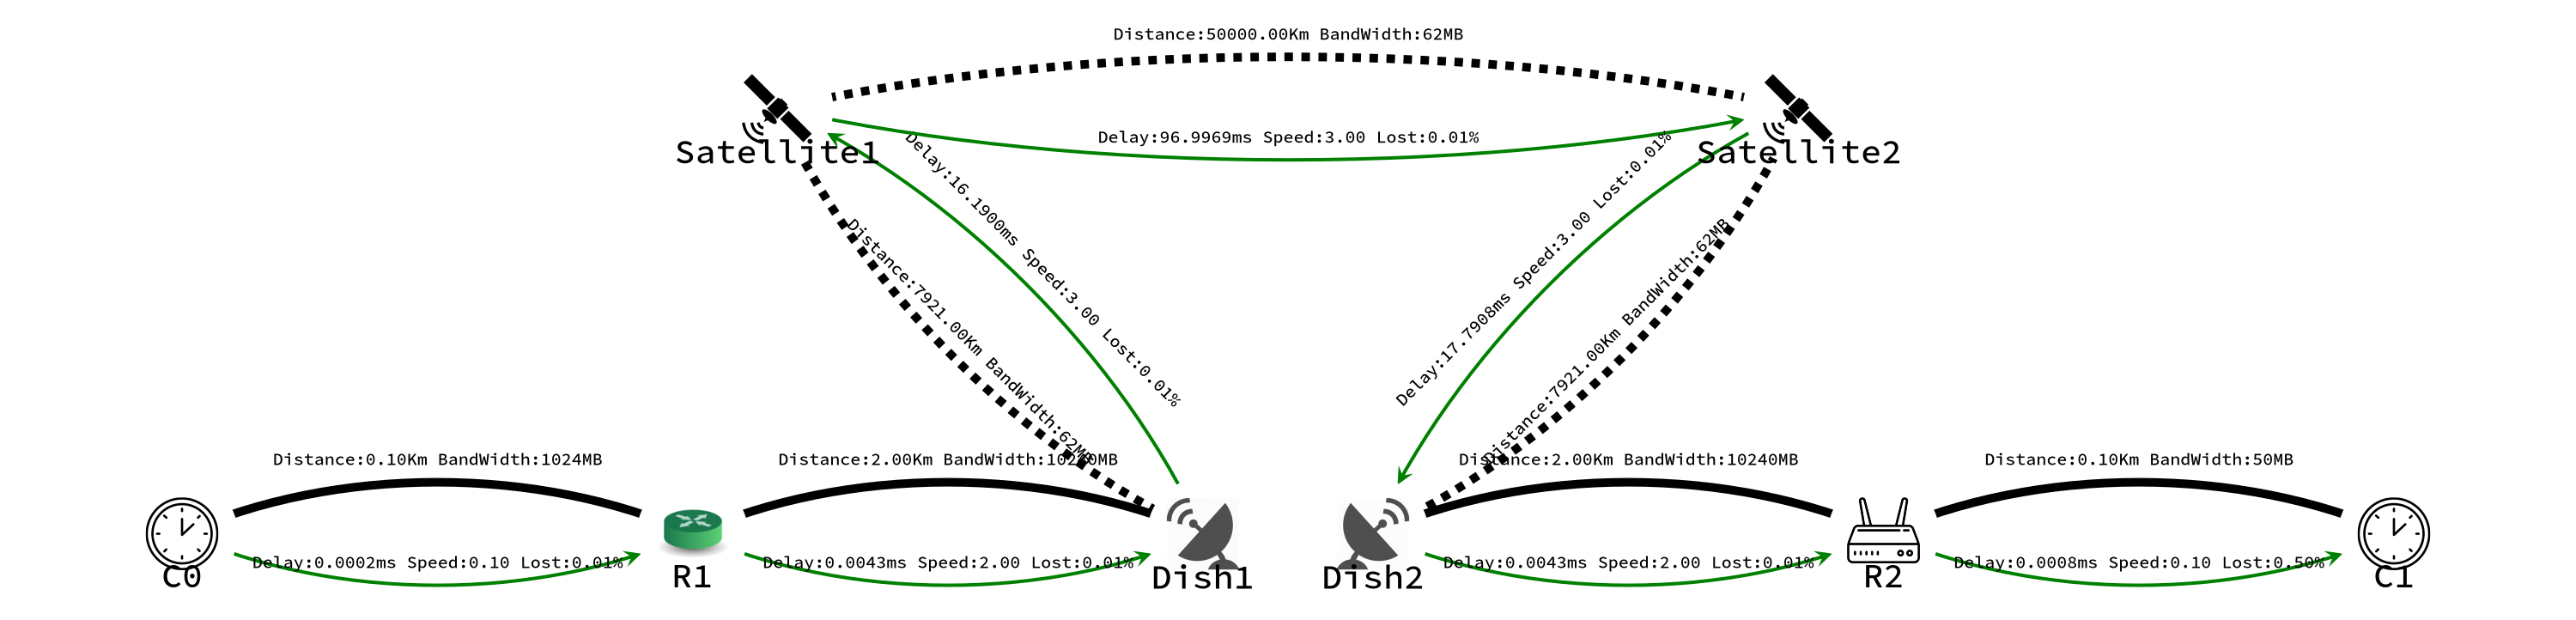

In [15]:
print(f'Total Package Size = {package_size}Byte')
a = graph_draw(g
               ,pos=g_pos
               ,vorder=g_vorder
               ,eorder=g_eorder
               ,vertex_text=g_v_label
               ,output_size=(1500,1500)
               ,vertex_surface=g_sfcs
               ,vertex_size=g_v_size
               ,vertex_color=g_v_color
               ,vertex_fill_color=g_v_fill_color
               ,vertex_halo=g_v_halo
               ,vertex_font_size=g_v_font_size
               ,vertex_halo_color=g_v_halo_color
               ,vertex_halo_size=g_v_halo_size
               ,vertex_text_offset=g_v_text_offset
               ,vertex_text_position=g_v_text_position
               ,vertex_pen_width=g_v_pen_width
               ,edge_end_marker=g_e_end_mark
               ,edge_pen_width=g_e_pen_width
               ,edge_marker_size=g_e_marker_size
               ,edge_text=g_e_text
               ,edge_text_parallel=g_e_text_parallel
               ,edge_font_size=g_e_text_font_size
               ,edge_color=g_e_color
               ,edge_text_distance=g_e_text_distance
               ,edge_dash_style = g_e_dash_style
#                ,output="output/sim_example_star_link.png"
              )